# 4. Tokenização

Este notebook tem como objetivo realizar a vetorização/tokenização de enunciados e alternativas de questões do ENEM utilizando diferentes modelos de *embeddings* de palavras (*Word2Vec* com 300, 100 e 50 dimensões). O fluxo inclui etapas de limpeza dos dados, geração dos vetores para enunciados, gabaritos e distratores, cálculo das similaridades de cosseno entre eles e visualização do espaço vetorial reduzido (PCA e t-SNE).


In [5]:
# Importando Dependências para Vetorização
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import plotly.express as px
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [ ]:
# Leitura do dataset
enem_df = pd.read_csv("../data/final/cleaned_data.csv")
enem_df.head(5)

,numero_questao,gabarito,NU_PARAM_A,nu_param_B,NU_PARAM_C,ANO,enunciado,alternativas,gabarito_texto,distratores,enunciado_limpo,alternativas_limpo,gabarito_texto_limpo,distratores_limpo
0,1,C,3.43894,0.97831,0.10855,2017,"No império africano do Mali, no século XIV, To...",A: isolamento geográﬁco do Saara ocidental; B...,posição relativa nas redes de circulação,isolamento geográﬁco do Saara ocidental; explo...,africano além astronomia centro cidade comérci...,A: isolamento ocidental saara; B: exploração i...,circulação posição redes relativa,competição econômica exploração intensiva isol...
1,2,D,3.00837,0.49169,0.13877,2017,Após a Declaração Universal dos Direitos Human...,A: ataque feito pelos japoneses à base milita...,execução de judeus e eslavos presos em guetos ...,ataque feito pelos japoneses à base militar am...,aberrações acontecimentos após assumida branco...,A: americana ataque base feito harbor japonese...,campos concentração eslavos execução guetos ju...,americana americanas ataque atômicas base bomb...
2,3,D,0.60432,3.25992,0.08798,2017,"A moralidade, Bentham exortava, não é uma ques...",A: fundamentação cientíﬁca de viés positivist...,racionalidade de caráter pragmático,fundamentação cientíﬁca de viés positivista; c...,abstratas afetados agradar ação bentham condut...,A: fundamentação positivista viés; B: convençã...,caráter pragmático racionalidade,comportamental convenção fundamentação inclina...
3,4,E,1.85031,0.57925,0.11344,2017,Fala-se muito nos dias de hoje em direitos do ...,A: modernização da educação escolar; B: atuali...,universalização do princípio da igualdade civil,modernização da educação escolar; atualização ...,apresenta assembleia bases bem cidadão concepç...,A: educação escolar modernização; B: atualizaç...,civil igualdade princípio universalização,aristocráticos atualização conhecimento costum...
4,5,C,2.46290,0.76307,0.17672,2017,Na Constituição da República Federativa do Bra...,A: etnia e miscigenação racial; B: sociedade...,espaço e sobrevivência cultural,etnia e miscigenação racial; sociedade e igual...,aplicação artigo bens brasil competindo consta...,A: etnia miscigenação racial; B: igualdade jur...,cultural espaço sobrevivência,ambiental bem econômica educação etnia igualda...


In [ ]:
# Função auxiliar que irá retornar os vetores de palavras
def generate_word2vec_embeddings(data, model):
    # Dicionário auxiliar que armazena palavras já encontradas
    vetor_cache = {}

    not_found_words = set()
    embeddings = []

    for item in data:
        word_vectors = []
        words = re.sub(r"[^\w\s]", "", item.lower()).split()

        for word in words:
            try:
                if word in vetor_cache:
                    word_vectors.append(vetor_cache[word])
                else:
                    vetor_cache[word] = model[word]
                    word_vectors.append(model[word])
            except KeyError:
                not_found_words.add(word)

        if word_vectors:
            # Calcula a média dos vetores
            mean_vector = np.mean(word_vectors, axis=0)
            embeddings.append(mean_vector)
        else:
            # Se não encontrou nenhuma palavra, adiciona um vetor nulo
            embeddings.append(np.zeros(model.vector_size))

    return embeddings, not_found_words

---

## 4.1. Word2Vec - 300 Dimensões


In [5]:
# Modelo de Embedding: Word2Vec NILC
# Download disponível em:
# http://nilc.icmc.usp.br/nilc/index.php/repositorio-de-word-embeddings-do-nilc
model_300 = KeyedVectors.load_word2vec_format("../data/embeddings/cbow_s300.txt")

### 4.1.1. Vetorização dos Enunciados


In [16]:
enem_df["enunciado_embbedings_word2vec_300"], not_found_words_enunciado = (
    generate_word2vec_embeddings(enem_df["enunciado_limpo"], model_300)
)
len(not_found_words_enunciado)

191

### 4.1.2. Vetorização dos Gabaritos


In [17]:
enem_df["gabarito_embbedings_word2vec_300"], not_found_words_gabarito = (
    generate_word2vec_embeddings(enem_df["gabarito_texto_limpo"].astype(str), model_300)
)
not_found_words_gabarito

{'biopolíticos',
 'conduzireis',
 'extrapeninsulares',
 'multiescalares',
 'socioafetivos'}

### 4.1.3. Vetorização dos Distratores


In [18]:
enem_df["distratores_embbedings_word2vec_300"], not_found_words_distratores = (
    generate_word2vec_embeddings(enem_df["distratores_limpo"], model_300)
)
len(not_found_words_distratores)

11

### 4.1.4. Cálculo das Similaridades


In [19]:
# Calculando a similaridade de cosseno entre os embeddings de 300 dim
# Similaridade entre enunciado e gabarito
enem_df["similaridade_enunciado_gabarito_300"] = [
    cosine_similarity([enunciado], [gabarito])[0][0]
    for enunciado, gabarito in zip(
        enem_df["enunciado_embbedings_word2vec_300"],
        enem_df["gabarito_embbedings_word2vec_300"],
    )
]

# Similaridade entre enunciado e distratores
enem_df["similaridade_enunciado_distratores_300"] = [
    cosine_similarity([enunciado], [distratores])[0][0]
    for enunciado, distratores in zip(
        enem_df["enunciado_embbedings_word2vec_300"],
        enem_df["distratores_embbedings_word2vec_300"],
    )
]

# Similaridade entre gabarito e distratores
enem_df["similaridade_gabarito_distratores_300"] = [
    cosine_similarity([gabarito], [distratores])[0][0]
    for gabarito, distratores in zip(
        enem_df["gabarito_embbedings_word2vec_300"],
        enem_df["distratores_embbedings_word2vec_300"],
    )
]

enem_df[
    [
        "similaridade_enunciado_gabarito_300",
        "similaridade_enunciado_distratores_300",
        "similaridade_gabarito_distratores_300",
    ]
].head()

,similaridade_enunciado_gabarito_300,similaridade_enunciado_distratores_300,similaridade_gabarito_distratores_300
0,0.141353,0.516898,0.151251
1,0.422576,0.313321,0.423611
2,0.427063,0.471643,0.602545
3,0.320939,0.482462,0.421501
4,0.304050,0.501346,0.411802


---

## 4.2. Word2Vec - 100 Dimensões


In [10]:
# Modelo de Embedding: Word2Vec NILC
# Download disponível em:
# http://nilc.icmc.usp.br/nilc/index.php/repositorio-de-word-embeddings-do-nilc
model_100 = KeyedVectors.load_word2vec_format("../data/embeddings/cbow_s100.txt")

### 4.2.1. Vetorização dos Enunciados


In [20]:
enem_df["enunciado_embbedings_word2vec_100"], not_found_words_enunciado_100 = (
    generate_word2vec_embeddings(enem_df["enunciado_limpo"], model_100)
)
len(not_found_words_enunciado_100)

191

### 4.2.2. Vetorização dos Gabaritos


In [23]:
enem_df["gabarito_embbedings_word2vec_100"], not_found_words_gabarito_100 = (
    generate_word2vec_embeddings(enem_df["gabarito_texto_limpo"].astype(str), model_100)
)
not_found_words_gabarito_100

{'biopolíticos',
 'conduzireis',
 'extrapeninsulares',
 'multiescalares',
 'socioafetivos'}

### 4.2.3. Vetorização dos Distratores


In [24]:
enem_df["distratores_embbedings_word2vec_100"], not_found_words_distratores_100 = (
    generate_word2vec_embeddings(enem_df["distratores_limpo"], model_100)
)
len(not_found_words_distratores_100)

11

### 4.2.4. Cálculo das Similaridades


In [25]:
# Calculando a similaridade de cosseno entre os embeddings de 100 dim
# Similaridade entre enunciado e gabarito
enem_df["similaridade_enunciado_gabarito_100"] = [
    cosine_similarity([enunciado], [gabarito])[0][0]
    for enunciado, gabarito in zip(
        enem_df["enunciado_embbedings_word2vec_100"],
        enem_df["gabarito_embbedings_word2vec_100"],
    )
]

# Similaridade entre enunciado e distratores
enem_df["similaridade_enunciado_distratores_100"] = [
    cosine_similarity([enunciado], [distratores])[0][0]
    for enunciado, distratores in zip(
        enem_df["enunciado_embbedings_word2vec_100"],
        enem_df["distratores_embbedings_word2vec_100"],
    )
]

# Similaridade entre gabarito e distratores
enem_df["similaridade_gabarito_distratores_100"] = [
    cosine_similarity([gabarito], [distratores])[0][0]
    for gabarito, distratores in zip(
        enem_df["gabarito_embbedings_word2vec_100"],
        enem_df["distratores_embbedings_word2vec_100"],
    )
]

enem_df[
    [
        "similaridade_enunciado_gabarito_100",
        "similaridade_enunciado_distratores_100",
        "similaridade_gabarito_distratores_100",
    ]
].head()

,similaridade_enunciado_gabarito_100,similaridade_enunciado_distratores_100,similaridade_gabarito_distratores_100
0,0.236482,0.699529,0.379381
1,0.517151,0.449300,0.560128
2,0.546526,0.564335,0.681273
3,0.382210,0.558623,0.591672
4,0.435788,0.628210,0.611719


---

## 4.3. Word2Vec - 50 Dimensões


In [26]:
# Modelo de Embedding: Word2Vec NILC
# Download disponível em:
# http://nilc.icmc.usp.br/nilc/index.php/repositorio-de-word-embeddings-do-nilc
model_50 = KeyedVectors.load_word2vec_format("../data/embeddings/cbow_s50.txt")

### 4.3.1. Vetorização dos Enunciados


In [27]:
enem_df["enunciado_embbedings_word2vec_50"], not_found_words_enunciado_50 = (
    generate_word2vec_embeddings(enem_df["enunciado_limpo"], model_50)
)
len(not_found_words_enunciado_50)

191

### 4.3.2. Vetorização dos Gabaritos


In [28]:
enem_df["gabarito_embbedings_word2vec_50"], not_found_words_gabarito_50 = (
    generate_word2vec_embeddings(enem_df["gabarito_texto_limpo"].astype(str), model_50)
)
not_found_words_gabarito_50

{'biopolíticos',
 'conduzireis',
 'extrapeninsulares',
 'multiescalares',
 'socioafetivos'}

### 4.3.3. Vetorização dos Distratores


In [29]:
enem_df["distratores_embbedings_word2vec_50"], not_found_words_distratores_50 = (
    generate_word2vec_embeddings(enem_df["distratores_limpo"], model_50)
)
len(not_found_words_distratores_50)

11

### 4.3.4. Cálculo das Similaridades


In [31]:
# Calculando a similaridade de cosseno entre os embeddings de 50 dim
# Similaridade entre enunciado e gabarito
enem_df["similaridade_enunciado_gabarito_50"] = [
    cosine_similarity([enunciado], [gabarito])[0][0]
    for enunciado, gabarito in zip(
        enem_df["enunciado_embbedings_word2vec_50"],
        enem_df["gabarito_embbedings_word2vec_50"],
    )
]

# Similaridade entre enunciado e distratores
enem_df["similaridade_enunciado_distratores_50"] = [
    cosine_similarity([enunciado], [distratores])[0][0]
    for enunciado, distratores in zip(
        enem_df["enunciado_embbedings_word2vec_50"],
        enem_df["distratores_embbedings_word2vec_50"],
    )
]

# Similaridade entre gabarito e distratores
enem_df["similaridade_gabarito_distratores_50"] = [
    cosine_similarity([gabarito], [distratores])[0][0]
    for gabarito, distratores in zip(
        enem_df["gabarito_embbedings_word2vec_50"],
        enem_df["distratores_embbedings_word2vec_50"],
    )
]

enem_df[
    [
        "similaridade_enunciado_gabarito_50",
        "similaridade_enunciado_distratores_50",
        "similaridade_gabarito_distratores_50",
    ]
].head()

,similaridade_enunciado_gabarito_50,similaridade_enunciado_distratores_50,similaridade_gabarito_distratores_50
0,0.251504,0.736054,0.426387
1,0.634785,0.504648,0.587013
2,0.655402,0.634760,0.763059
3,0.485125,0.628863,0.766145
4,0.559584,0.707497,0.692311


---

## 4.4. Visualização do Espaço Vetorial


### 4.4.1. Análise de Componentes Principais (PCA)


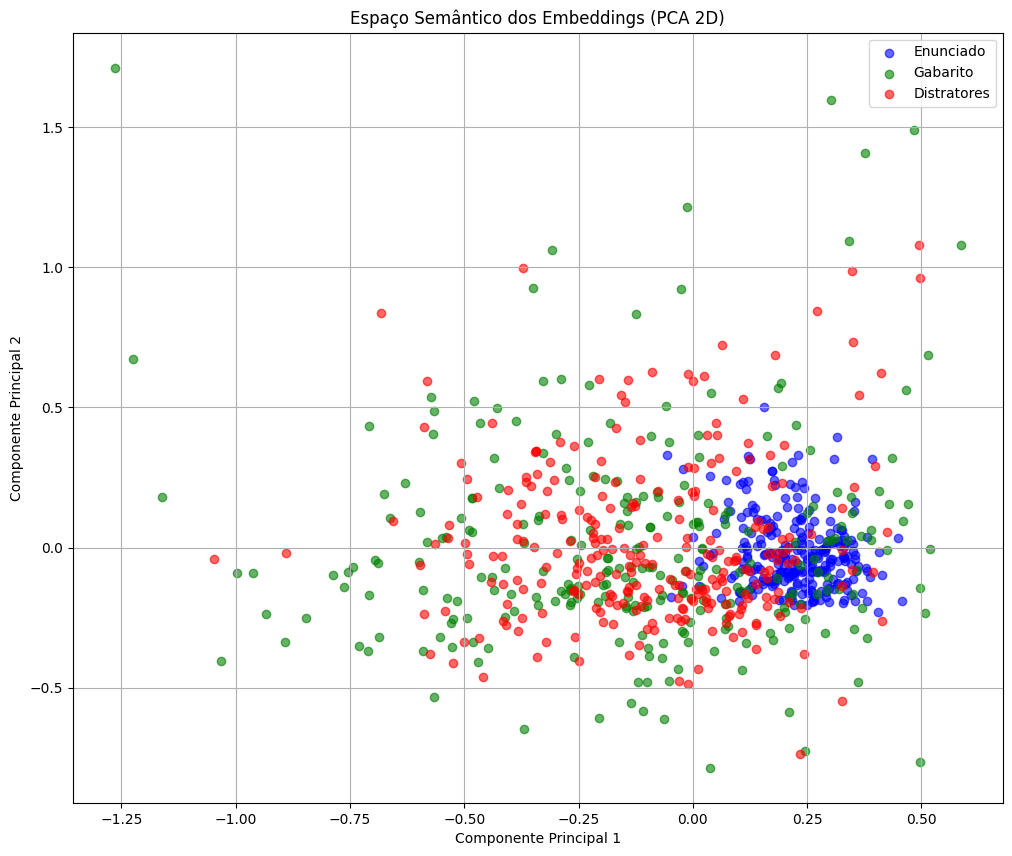

In [7]:
# Coleta os vetores dos enunciados, gabaritos e distratores de 300 dimensões
enunciados = np.vstack(enem_df["enunciado_embbedings_word2vec_300"])
gabaritos = np.vstack(enem_df["gabarito_embbedings_word2vec_300"])
distratores = np.vstack(enem_df["distratores_embbedings_word2vec_300"])

# Reduz para 2 dimensões usando PCA
pca = PCA(n_components=2)
all_vectors = np.vstack([enunciados, gabaritos, distratores])
pca_result = pca.fit_transform(all_vectors)
n = len(enem_df)

plt.figure(figsize=(12, 10))
plt.scatter(
    pca_result[:n, 0], pca_result[:n, 1], c="blue", label="Enunciado", alpha=0.6
)
plt.scatter(
    pca_result[n : 2 * n, 0],
    pca_result[n : 2 * n, 1],
    c="green",
    label="Gabarito",
    alpha=0.6,
)
plt.scatter(
    pca_result[2 * n :, 0],
    pca_result[2 * n :, 1],
    c="red",
    label="Distratores",
    alpha=0.6,
)
plt.legend()
plt.title("Espaço Semântico dos Embeddings (PCA 2D)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.grid(True)
plt.show()

In [8]:
# PCA para 3 componentes
pca = PCA(n_components=3)
pca_result = pca.fit_transform(all_vectors)
n = len(enem_df)
labels = ["Enunciado"] * n + ["Gabarito"] * n + ["Distrator"] * n

# Armazenando os resultados do PCA em um DataFrame
df_pca = pd.DataFrame(data=pca_result, columns=["PC1", "PC2", "PC3"])
df_pca["Categoria"] = labels

# Criando o gráfico 3D interativo com Plotly
fig = px.scatter_3d(
    df_pca,
    x="PC1",
    y="PC2",
    z="PC3",
    color="Categoria",
    title="Espaço Vetorial PCA 3D Interativo",
    color_discrete_map={
        "Enunciado": "blue",
        "Gabarito": "green",
        "Distrator": "red",
    },
    hover_name="Categoria",
)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=40))  # Remove margens excessivas
fig.update_traces(marker=dict(size=3, opacity=0.7))  # Diminui o tamanho dos pontos

fig.show()


Variância Total Explicada: 15.09%


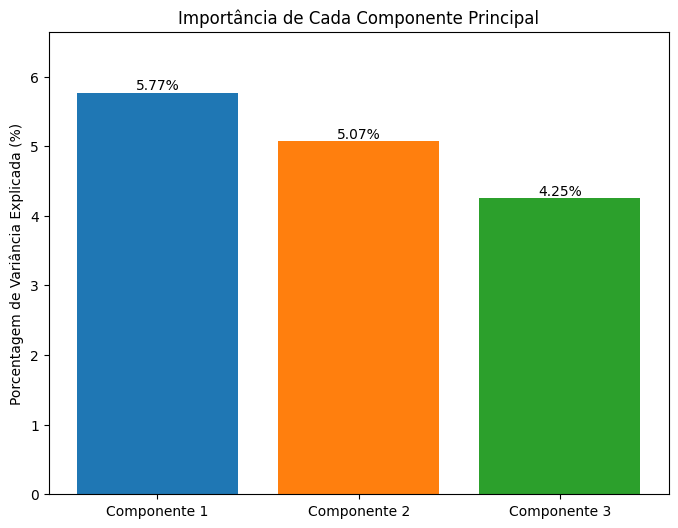

In [ ]:
# Analisando variância explicada pelos componentes principais
explained_variance = pca.explained_variance_ratio_

# Total explicada pelos 3 componentes
print(f"\nVariância Total Explicada: {sum(explained_variance) * 100:.2f}%")

component_labels = [f"Componente {i+1}" for i in range(len(explained_variance))]
plt.figure(figsize=(8, 6))
bars = plt.bar(
    component_labels, explained_variance * 100, color=["#1f77b4", "#ff7f0e", "#2ca02c"]
)

# Adiciona os valores em cima das barras
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        yval,
        f"{yval:.2f}%",
        va="bottom",
        ha="center",
    )  # centralizado

plt.ylabel("Porcentagem de Variância Explicada (%)")
plt.title("Importância de Cada Componente Principal")
plt.ylim(0, max(explained_variance * 100) * 1.15)
plt.show()

### 4.4.2. t-SNE


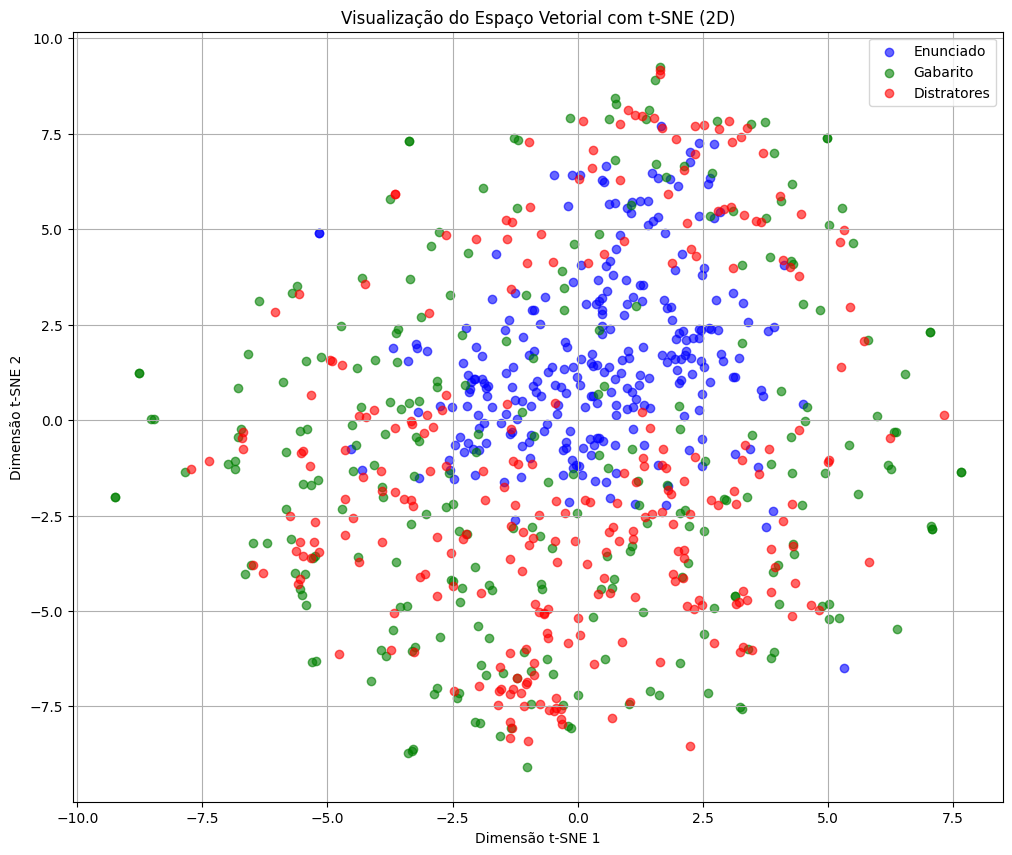

In [10]:
# Aplicando t-SNE para redução de dimensionalidade
tsne = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=300)
tsne_results = tsne.fit_transform(all_vectors)
n = len(enem_df)

plt.figure(figsize=(12, 10))

# Plotando Enunciados
plt.scatter(
    tsne_results[:n, 0], tsne_results[:n, 1], c="blue", label="Enunciado", alpha=0.6
)

# Plotando Gabaritos
plt.scatter(
    tsne_results[n : 2 * n, 0],
    tsne_results[n : 2 * n, 1],
    c="green",
    label="Gabarito",
    alpha=0.6,
)

# Plotando Distratores
plt.scatter(
    tsne_results[2 * n :, 0],
    tsne_results[2 * n :, 1],
    c="red",
    label="Distratores",
    alpha=0.6,
)

plt.title("Visualização do Espaço Vetorial com t-SNE (2D)")
plt.xlabel("Dimensão t-SNE 1")
plt.ylabel("Dimensão t-SNE 2")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Diverrgência KL do t-SNE
final_kl_divergence = tsne.kl_divergence_

print(f"A Divergência KL final do t-SNE foi: {final_kl_divergence:.4f}")

A Divergência KL final do t-SNE foi: 1.8304


---

## 4.5. Salvando Resultados


In [36]:
enem_df.to_pickle("../data/final/enem_data_embeddings.pkl")

In [37]:
enem_df.head()

,numero_questao,gabarito,NU_PARAM_A,nu_param_B,NU_PARAM_C,ANO,enunciado,alternativas,gabarito_texto,distratores,...,distratores_embbedings_word2vec_100,similaridade_enunciado_gabarito_100,similaridade_enunciado_distratores_100,similaridade_gabarito_distratores_100,enunciado_embbedings_word2vec_50,gabarito_embbedings_word2vec_50,distratores_embbedings_word2vec_50,similaridade_enunciado_gabarito_50,similaridade_enunciado_distratores_50,similaridade_gabarito_distratores_50
0,1,C,3.43894,0.97831,0.10855,2017,"No império africano do Mali, no século XIV, To...",A: isolamento geográﬁco do Saara ocidental; B...,posição relativa nas redes de circulação,isolamento geográﬁco do Saara ocidental; explo...,...,"[0.041403063, -0.019931864, 0.13105607, -0.080...",0.236482,0.699529,0.379381,"[0.09772969, 0.013166125, -0.032748703, 0.0580...","[-0.04434625, 0.2105245, -0.18144351, 0.030336...","[0.12940213, 0.22066694, 0.0586984, 0.03139533...",0.251504,0.736054,0.426387
1,2,D,3.00837,0.49169,0.13877,2017,Após a Declaração Universal dos Direitos Human...,A: ataque feito pelos japoneses à base milita...,execução de judeus e eslavos presos em guetos ...,ataque feito pelos japoneses à base militar am...,...,"[-0.008315361, 0.010459961, 0.008144858, 0.036...",0.517151,0.449300,0.560128,"[-0.018823402, 0.07832528, -0.016192827, 0.027...","[0.21008351, 0.5248949, 0.03625112, 0.01772637...","[0.078055575, 0.19092263, -0.0076030395, -0.03...",0.634785,0.504648,0.587013
2,3,D,0.60432,3.25992,0.08798,2017,"A moralidade, Bentham exortava, não é uma ques...",A: fundamentação cientíﬁca de viés positivist...,racionalidade de caráter pragmático,fundamentação cientíﬁca de viés positivista; c...,...,"[0.2935421, -0.019240078, 0.0034812312, 0.0143...",0.546526,0.564335,0.681273,"[-0.013062097, 0.038470805, -0.020605344, 0.05...","[0.16413634, -0.035050992, 0.08454134, 0.23227...","[0.1313074, 0.058539692, 0.0961813, 0.17813754...",0.655402,0.634760,0.763059
3,4,E,1.85031,0.57925,0.11344,2017,Fala-se muito nos dias de hoje em direitos do ...,A: modernização da educação escolar; B: atuali...,universalização do princípio da igualdade civil,modernização da educação escolar; atualização ...,...,"[0.05247575, 0.061523248, 0.010398333, 0.12163...",0.382210,0.558623,0.591672,"[-0.042833664, -0.01434522, -0.002431296, 0.01...","[0.102909006, 0.06116425, -0.13846825, 0.33034...","[0.11364358, 0.071867414, 0.046681672, 0.18046...",0.485125,0.628863,0.766145
4,5,C,2.46290,0.76307,0.17672,2017,Na Constituição da República Federativa do Bra...,A: etnia e miscigenação racial; B: sociedade...,espaço e sobrevivência cultural,etnia e miscigenação racial; sociedade e igual...,...,"[0.13021359, 0.0043819174, -0.019453753, 0.061...",0.435788,0.628210,0.611719,"[0.010493249, 0.11095436, 0.017243173, 0.05319...","[0.267512, -0.081234336, 0.08019033, 0.1294613...","[0.13863416, 0.16260158, -0.0043905806, 0.2472...",0.559584,0.707497,0.692311


---
